# Routing, speed imputation, and travel times

Including parallelized shortest-path solving via built-in multiprocessing in OSMnx.

Author: [Geoff Boeing](https://geoffboeing.com/)

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Documentation](https://osmnx.readthedocs.io/en/stable/)
  - [Journal article/citation](http://geoffboeing.com/publications/osmnx-complex-street-networks/)

In [1]:
import numpy as np
import osmnx as ox

%matplotlib inline
np.random.seed(0)
ox.__version__

'1.1.2'

In [2]:
place = "Piedmont, California, USA"
G = ox.graph_from_place(place, network_type="drive")
Gp = ox.project_graph(G)

## 1. Fast nearest node/edge search with OSMnx

The nearest_nodes and nearest_edges functions take arrays of x and y (or lng/lat) coordinates and return the nearest node/edge to each.

In [3]:
# randomly sample n points spatially-constrained to the network's geometry
points = ox.utils_geo.sample_points(ox.get_undirected(Gp), n=100)
X = points.x.values
Y = points.y.values
X0 = X.mean()
Y0 = Y.mean()

In [4]:
# find each nearest node to several points, and optionally return distance
nodes, dists = ox.nearest_nodes(Gp, X, Y, return_dist=True)

In [5]:
# or, find the nearest node to a single point
node = ox.nearest_nodes(Gp, X0, Y0)
node

53021743

In [6]:
# find each nearest edge to several points, and optionally return distance
edges, dists = ox.nearest_edges(Gp, X, Y, return_dist=True)

In [7]:
# find the nearest edge to a single point
edge = ox.nearest_edges(Gp, X0, Y0)
edge

(53021743, 53021743, 1)

## 2. Basic routing by distance

Pick two nodes. Then find the shortest path between origin and destination, using weight='length' to find the shortest path by minimizing distance traveled (otherwise it treats each edge as weight=1).

In [12]:
len(list(G))

346

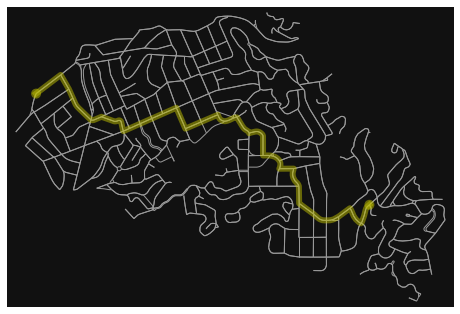

In [15]:
# find the shortest path (by distance) between these nodes then plot it
orig = list(G)[0]
dest = list(G)[120]
route = ox.shortest_path(G, orig, dest, weight="length")
fig, ax = ox.plot_graph_route(G, route, route_color="y", route_linewidth=6, node_size=0)

In [33]:
dest

53080198

In [16]:
route

[53017091,
 53064327,
 53064328,
 53018404,
 53114726,
 53114727,
 53119162,
 53081990,
 53119164,
 53041443,
 53042707,
 53119166,
 53025057,
 2834814897,
 53025060,
 53082627,
 53073691,
 53033660,
 53040495,
 53027455,
 53027457,
 2391023394,
 53027459,
 53027461,
 53046249,
 53046250,
 53046251,
 53125997,
 53124805,
 2518218246,
 53125999,
 53126000,
 53092218,
 53080198]

Or get *k* shortest paths, weighted by some attribute:

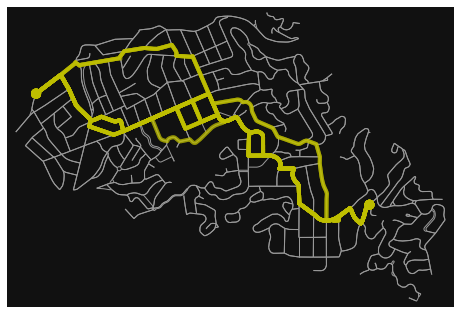

In [18]:
routes = ox.k_shortest_paths(G, orig, dest, k=30, weight="length")
# print(list(routes))
fig, ax = ox.plot_graph_routes(G, list(routes), route_colors="y", route_linewidth=4, node_size=0)

In [26]:
print(list(routes))

[]


## 3. Imputing travel speeds and times

The `add_edge_speeds` function add edge speeds (km per hour) to graph as new `speed_kph` edge attributes. Imputes free-flow travel speeds for all edges based on mean `maxspeed` value of edges, per highway type. This mean-imputation can obviously be imprecise, and the caller can override it by passing in `hwy_speeds` and/or `fallback` arguments that correspond to local speed limit standards. See docstring for details.

In [19]:
# impute speed on all edges missing data
G = ox.add_edge_speeds(G)

# calculate travel time (seconds) for all edges
G = ox.add_edge_travel_times(G)

In [20]:
# see mean speed/time values by road type
edges = ox.graph_to_gdfs(G, nodes=False)
edges["highway"] = edges["highway"].astype(str)
edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)

,length,speed_kph,travel_time
highway,,,
residential,124.9,24.1,18.7
secondary,117.3,44.3,9.7
tertiary,106.7,40.2,9.6
tertiary_link,74.7,36.2,7.4
unclassified,28.8,36.2,2.9


In [23]:
# same thing again, but this time pass in a few default speed values (km/hour)
# to fill in edges with missing `maxspeed` from OSM
hwy_speeds = {"residential": 35, "secondary": 50, "tertiary": 60}
G = ox.add_edge_speeds(G, hwy_speeds)
G = ox.add_edge_travel_times(G)

In [24]:
edges = ox.graph_to_gdfs(G, nodes=False)
edges

osmid  \
u          v          key                          
53017091   53064327   0                  6345781   
           53075599   0                  6345781   
53018397   53097980   0                196739937   
           53018399   0                  6327298   
           53018411   0                196739937   
...                                          ...   
9124766429 53076244   0                472982274   
           53075606   0                987189926   
           53076245   0                987189927   
9231102999 2391023380 0    [6347648, 1000044348]   
           53152083   0               1000044348   

                                                    name      highway  oneway  \
u          v          key                                                       
53017091   53064327   0                      Rose Avenue  residential   False   
           53075599   0                      Rose Avenue  residential   False   
53018397   53097980   0                     Linda Avenue     tertiary   False   
           53018399   0                      Lake Avenue  residential   False   
           53018411   0                     Linda Avenue     tertiary   False   
...                                                  ...          ...     ...   
9124766429 53076244   0                    Arroyo Avenue  residential   False   
           53075606   0                     Grand Avenue    secondary    True   
           53076245   0                    Arroyo Avenue  residential   False   
9231102999 2391023380 0    [Magnolia Avenue, Nova Drive]  residential   False   
           53152083   0                       Nova Drive  residential   False   

                            length  speed_kph  travel_time  \
u          v          key                                    
53017091   53064327   0    231.335       35.0         23.8   
           53075599   0    121.114       35.0         12.5   
53018397   53097980   0    100.767       60.0          6.0   
           53018399   0    124.622       35.0         12.8   
           53018411   0     37.803       60.0          2.3   
...                            ...        ...          ...   
9124766429 53076244   0      8.160       35.0          0.8   
           53075606   0     43.772       50.0          3.2   
           53076245   0     42.012       35.0          4.3   
9231102999 2391023380 0     31.512       35.0          3.2   
           53152083   0     26.814       35.0          2.8   

                                                                    geometry  \
u          v          key                                                      
53017091   53064327   0    LINESTRING (-122.24760 37.82625, -122.24551 37...   
           53075599   0    LINESTRING (-122.24760 37.82625, -122.24770 37...   
53018397   53097980   0    LINESTRING (-122.24719 37.82422, -122.24777 37...   
           53018399   0    LINESTRING (-122.24719 37.82422, -122.24712 37...   
           53018411   0    LINESTRING (-122.24719 37.82422, -122.24713 37...   
...                                                                      ...   
9124766429 53076244   0    LINESTRING (-122.24383 37.82817, -122.24391 37...   
           53075606   0    LINESTRING (-122.24383 37.82817, -122.24398 37...   
           53076245   0    LINESTRING (-122.24383 37.82817, -122.24380 37...   
9231102999 2391023380 0    LINESTRING (-122.24130 37.82021, -122.24116 37...   
           53152083   0    LINESTRING (-122.24130 37.82021, -122.24145 37...   

                          lanes maxspeed bridge junction  
u          v          key                                 
53017091   53064327   0     NaN      NaN    NaN      NaN  
           53075599   0     NaN      NaN    NaN      NaN  
53018397   53097980   0     NaN      NaN    NaN      NaN  
           53018399   0     NaN      NaN    NaN      NaN  
           53018411   0     NaN      NaN    NaN      NaN  
...                         ...      ...    ...    

In [25]:
# calculate two routes by minimizing travel distance vs travel time
orig = list(G)[1]
dest = list(G)[120]
route1 = ox.shortest_path(G, orig, dest, weight="length")
route2 = ox.shortest_path(G, orig, dest, weight="travel_time")

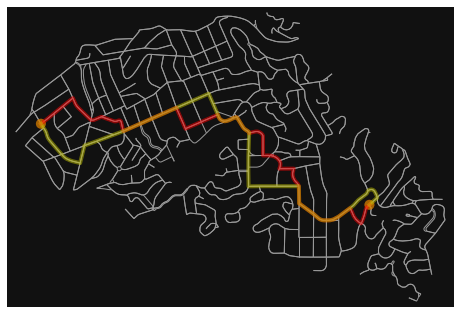

In [26]:
# plot the routes
fig, ax = ox.plot_graph_routes(
    G, routes=[route1, route2], route_colors=["r", "y"], route_linewidth=6, node_size=0
)

In [27]:
# compare the two routes
route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, "length")))
route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, "length")))
route1_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, "travel_time")))
route2_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, "travel_time")))
print("Route 1 is", route1_length, "meters and takes", route1_time, "seconds.")
print("Route 2 is", route2_length, "meters and takes", route2_time, "seconds.")

Route 1 is 3624 meters and takes 322 seconds.
Route 2 is 3804 meters and takes 251 seconds.


The yellow route minimizes travel time, and is thus longer but faster than the red route.

For more examples of travel time, see the [isochrones example](13-isolines-isochrones.ipynb).

For more examples of routing, including using elevation as an impedance, see the [elevations example](12-node-elevations-edge-grades.ipynb).

## 4. Multiprocessing

Calculating lots of shortest paths can be slow, but OSMnx has built-in shortest path solver parallelization and multiprocessing. With the `shortest_path` function, you can pass in a single origin-destination pair to solve the one shortest path, or you can pass in lists of origins and destinations to solve each shortest path between the pairs. If you're solving shortest paths for multiple origins/destinations, the `cpus` argument determines how many CPU cores to utilize for parallelized solving. Multiprocessing adds some overhead, so it's only faster if you're solving a lot of paths. It also has substantial RAM requirements (as it must copy the graph into each sub-process), so be carefuly with your RAM when setting the `cpus` argument.

In [28]:
# calculate 100,000 shortest-path routes using random origin-destination pairs
n = 100000
origs = np.random.choice(G.nodes, size=n, replace=True)
dests = np.random.choice(G.nodes, size=n, replace=True)

In [29]:
%%time
# it takes 3.2 seconds to solve all the routes using all the cores on my computer
# I have a 24-thread AMD 5900x: performance will depend on your specific CPU
# routes = ox.shortest_path(G, origs, dests, weight="travel_time", cpus=None)
routes = ox.shortest_path(G, origs, dests, weight="travel_time")

Wall time: 55.2 s


In [30]:
%%time
# it takes 43 seconds to solve all the routes using just 1 core on my computer
routes = ox.shortest_path(G, origs, dests, weight="travel_time", cpus=1)

Wall time: 1min


In [31]:
# how many total results did we get
print(len(routes))

# and how many were solvable paths
# some will be unsolvable due to directed graph perimeter effects
routes_valid = [r for r in routes if r is not None]
print(len(routes_valid))

100000
99109


## 5. Miscellaneous routing notes

The routing correctly handles one-way streets:

In [ ]:
G2 = ox.graph_from_address(
    "N. Sicily Pl., Chandler, Arizona",
    dist=800,
    network_type="drive",
    truncate_by_edge=True,
)
origin = (33.307792, -111.894940)
destination = (33.312994, -111.894998)
origin_node = ox.distance.nearest_nodes(G2, origin[1], origin[0])
destination_node = ox.distance.nearest_nodes(G2, destination[1], destination[0])
route = ox.shortest_path(G2, origin_node, destination_node)
fig, ax = ox.plot_graph_route(G2, route, route_color="c", node_size=0)

Also, when there are parallel edges between nodes in the route, OSMnx picks the shortest edge to plot:

In [ ]:
location_point = (33.299896, -111.831638)
G2 = ox.graph_from_point(location_point, dist=400, truncate_by_edge=True)
origin = (33.301821, -111.829871)
destination = (33.301402, -111.833108)
origin_node = ox.distance.nearest_nodes(G2, origin[1], origin[0])
destination_node = ox.distance.nearest_nodes(G2, destination[1], destination[0])
route = ox.shortest_path(G2, origin_node, destination_node)
fig, ax = ox.plot_graph_route(G2, route, route_color="c", node_size=0)